In [1]:
import pandas as pd
import numpy as np
import warnings
import os

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import skew, kurtosis
import itertools
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')


In [2]:
file_path = 'MSF_1996_2023.csv'
data = pd.read_csv(file_path)

data

,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,RETX,vwretd
0,10001,1996-01-31,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.75000,9.50000,-9.12500,168.0,-0.026667,8.75000,9.50000,2281.0,-0.026667,0.028121
1,10001,1996-02-29,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.75000,9.50000,9.25000,524.0,0.013699,9.25000,9.75000,2281.0,0.013699,0.016353
2,10001,1996-03-29,11,4920,EWST,ENERGY WEST INC,7953,36720410,9.25000,9.75000,9.48438,283.0,0.036149,9.00000,9.50000,2309.0,0.025338,0.010914
3,10001,1996-04-30,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.62500,9.37500,-8.81250,327.0,-0.070840,8.62500,9.00000,2309.0,-0.070840,0.025560
4,10001,1996-05-31,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.62500,9.00000,8.62500,103.0,-0.021277,8.62500,9.00000,2309.0,-0.021277,0.026810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636558,93436,2023-08-31,11,9999,TSLA,TESLA INC,53453,88160R10,215.49001,261.07001,258.07999,25029170.0,-0.034962,258.07001,258.09000,3173994.0,-0.034962,-0.020605
1636559,93436,2023-09-29,11,9999,TSLA,TESLA INC,53453,88160R10,240.50000,276.04001,250.22000,24395440.0,-0.030456,250.23000,250.31000,3179000.0,-0.030456,-0.047390
1636560,93436,2023-10-31,11,9999,TSLA,TESLA INC,53453,88160R10,197.36000,263.62000,200.84000,25905681.0,-0.197346,200.77000,200.89000,3178921.0,-0.197346,-0.028867
1636561,93436,2023-11-30,11,9999,TSLA,TESLA INC,53453,88160R10,205.66000,246.72000,240.08000,26395792.0,0.195379,239.95000,240.10001,3178921.0,0.195379,0.092057


In [3]:
data['date'] = pd.to_datetime(data['date'])
filtered_data = data[(data['date'] >= '2005-01-01') & (data['date'] <= '2023-12-31')]

industry_codes = filtered_data['SICCD'].unique()

def sample_firms_per_industry_per_year(df, industry_codes):
    sampled_data = []
    
    for year in range(2005, 2024):
        yearly_data = df[df['date'].dt.year == year]
        
        for industry in industry_codes:
            industry_data = yearly_data[yearly_data['SICCD'] == industry]
            
            if len(industry_data) > 100:
                sampled_industry = industry_data.sample(10, random_state=42)
            else:
                continue
            
            sampled_data.append(sampled_industry)
    
    return pd.concat(sampled_data)

sampled_data = sample_firms_per_industry_per_year(filtered_data, industry_codes)

sampled_data.reset_index(drop=True, inplace=True)
sampled_data

,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,RETX,vwretd
0,86576,2005-03-31,11,6020,GBTB,G B & T BANCSHARES INC,16371,36146210,21.66,23.4876,21.660,8814.0,-0.067986,21.61,21.64,11790.0,-0.067986,-0.016944
1,86245,2005-08-31,11,6020,BWCF,B W C FINANCIAL CORP,16220,05604210,27.92,30.0000,27.920,871.0,-0.111076,27.60,28.00,4173.0,-0.113932,-0.005958
2,10913,2005-05-31,11,6020,FFKT,FARMERS CAPITAL BANK CORP,8788,30956210,32.25,33.5500,32.640,1125.0,0.006718,32.91,33.07,6782.0,-0.003359,0.037954
3,84140,2005-12-30,11,6020,UBCD,UNIONBANCORP INC,14996,15643B20,-21.00,21.4600,-21.075,223.0,-0.011955,20.90,21.25,3807.0,-0.011955,0.003458
4,10650,2005-09-30,11,6020,AABC,ACCESS ANYTIME BANCORP,8552,00431F10,16.06,17.8500,17.170,4785.0,0.194019,16.58,16.93,1634.0,0.194019,0.010600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16185,54148,2023-01-31,11,1531,PHM,PULTE GROUP INC,21349,74586710,46.20,56.8900,56.890,456711.0,0.249506,56.93,56.95,227820.0,0.249506,0.071823
16186,92089,2023-01-31,11,1531,GRBK,GREEN BRICK PARTNERS INC,52369,39270910,24.80,31.2000,31.200,59941.0,0.287660,31.20,31.21,46038.0,0.287660,0.071823
16187,77661,2023-06-30,11,1531,DHI,D R HORTON INC,11559,23331A10,108.48,123.0500,121.690,618202.0,0.138993,121.69,121.70,341071.0,0.138993,0.066183
16188,77661,2023-07-31,11,1531,DHI,D R HORTON INC,11559,23331A10,114.86,131.0000,127.020,643420.0,0.043800,127.01,127.02,338297.0,0.043800,0.035624


In [4]:
sampled_data = sampled_data[~sampled_data['SICCD'].str.contains(r'[A-Z]', na=False)]
sampled_data = sampled_data[~sampled_data['RET'].str.contains(r'[A-Z]', na=False)]
sampled_data = sampled_data.dropna()
sampled_data.reset_index(drop=True, inplace=True)
sampled_data1 = sampled_data
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15761 entries, 0 to 15760
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PERMNO  15761 non-null  int64         
 1   date    15761 non-null  datetime64[ns]
 2   SHRCD   15761 non-null  int64         
 3   SICCD   15761 non-null  object        
 4   TICKER  15761 non-null  object        
 5   COMNAM  15761 non-null  object        
 6   PERMCO  15761 non-null  int64         
 7   CUSIP   15761 non-null  object        
 8   BIDLO   15761 non-null  float64       
 9   ASKHI   15761 non-null  float64       
 10  PRC     15761 non-null  float64       
 11  VOL     15761 non-null  float64       
 12  RET     15761 non-null  object        
 13  BID     15761 non-null  float64       
 14  ASK     15761 non-null  float64       
 15  SHROUT  15761 non-null  float64       
 16  RETX    15761 non-null  object        
 17  vwretd  15761 non-null  float64       
dtypes: dat

In [5]:
def create_features_and_labels(df, window_size=12):
    features = []
    labels = []
    
    for i in range(window_size, len(df)):
        feature_set = df.iloc[i-window_size:i][['RET', 'vwretd']].values.flatten()
        features.append(feature_set)
        labels.append(df.iloc[i]['RET'])
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

features, labels = create_features_and_labels(sampled_data)

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

class NeuralBetaModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralBetaModel, self).__init__()
        self.hidden_layer = nn.Linear(input_size, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

input_size = X_train.shape[1]
model = NeuralBetaModel(input_size)

def custom_loss_function(predictions, actuals, market_returns):
    return torch.sqrt(torch.mean((actuals - predictions.squeeze() * market_returns) ** 2))

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        batch_features = X_train_tensor[i:i + batch_size]
        batch_labels = y_train_tensor[i:i + batch_size]
        
        # Ensure market returns tensor is the correct size
        market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[i:i + len(batch_labels)]
        
        predictions = model(batch_features).squeeze()
        loss = custom_loss_function(predictions, batch_labels, market_returns)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[:len(X_val_tensor)]
            val_predictions = model(X_val_tensor).squeeze()
            val_loss = custom_loss_function(val_predictions, y_val_tensor, val_market_returns)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')


Epoch [10/100], Validation Loss: 0.1670
Epoch [20/100], Validation Loss: 0.1670
Epoch [30/100], Validation Loss: 0.1670
Epoch [40/100], Validation Loss: 0.1671
Epoch [50/100], Validation Loss: 0.1672
Epoch [60/100], Validation Loss: 0.1672
Epoch [70/100], Validation Loss: 0.1672
Epoch [80/100], Validation Loss: 0.1673
Epoch [90/100], Validation Loss: 0.1674
Epoch [100/100], Validation Loss: 0.1675


In [7]:
import itertools
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

neurons_options = [32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'sigmoid', 'tanh']
look_back_windows = [12, 24, 36]

def create_features_and_labels(df, window_size):
    features = []
    labels = []
    
    for i in range(window_size, len(df)):
        feature_set = df.iloc[i-window_size:i][['RET', 'vwretd']].values.flatten()
        features.append(feature_set)
        labels.append(df.iloc[i]['RET'])
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

class TuningNeuralBetaModel(nn.Module):
    def __init__(self, input_size, hidden_neurons, activation_fn):
        super(TuningNeuralBetaModel, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_neurons)
        self.activation_fn = activation_fn
        self.output_layer = nn.Linear(hidden_neurons, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        if self.activation_fn == 'relu':
            x = torch.relu(x)
        elif self.activation_fn == 'sigmoid':
            x = torch.sigmoid(x)
        elif self.activation_fn == 'tanh':
            x = torch.tanh(x)
        x = self.output_layer(x)
        return x

results = []

for neurons, lr, activation, window in itertools.product(neurons_options, learning_rates, activation_functions, look_back_windows):
    print(f'Tuning with {neurons} neurons, learning rate {lr}, activation {activation}, look back window {window}')
    features, labels = create_features_and_labels(sampled_data, window)
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)

    input_size = X_train.shape[1]
    model = TuningNeuralBetaModel(input_size, neurons, activation)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch_losses = []

    num_epochs = 100
    batch_size = 32

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            optimizer.zero_grad()
            batch_features = X_train_tensor[i:i + batch_size]
            batch_labels = y_train_tensor[i:i + batch_size]
            market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[i:i + len(batch_labels)]
            predictions = model(batch_features).squeeze()
            loss = custom_loss_function(predictions, batch_labels, market_returns)
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[:len(X_val_tensor)]
        val_predictions = model(X_val_tensor).squeeze()
        val_loss = custom_loss_function(val_predictions, y_val_tensor, val_market_returns)
        results.append((neurons, lr, activation, window, val_loss.item(), epoch_losses))

Tuning with 32 neurons, learning rate 0.001, activation relu, look back window 12
Tuning with 32 neurons, learning rate 0.001, activation relu, look back window 24
Tuning with 32 neurons, learning rate 0.001, activation relu, look back window 36
Tuning with 32 neurons, learning rate 0.001, activation sigmoid, look back window 12
Tuning with 32 neurons, learning rate 0.001, activation sigmoid, look back window 24
Tuning with 32 neurons, learning rate 0.001, activation sigmoid, look back window 36
Tuning with 32 neurons, learning rate 0.001, activation tanh, look back window 12
Tuning with 32 neurons, learning rate 0.001, activation tanh, look back window 24
Tuning with 32 neurons, learning rate 0.001, activation tanh, look back window 36
Tuning with 32 neurons, learning rate 0.01, activation relu, look back window 12
Tuning with 32 neurons, learning rate 0.01, activation relu, look back window 24
Tuning with 32 neurons, learning rate 0.01, activation relu, look back window 36
Tuning wit

In [13]:
import csv
result_csv = pd.DataFrame(results, columns=['column1', 'column2', 'columns3','column4', 'column5', 'columns6'])
result_csv.to_csv('grid_search_results.csv', index=False)

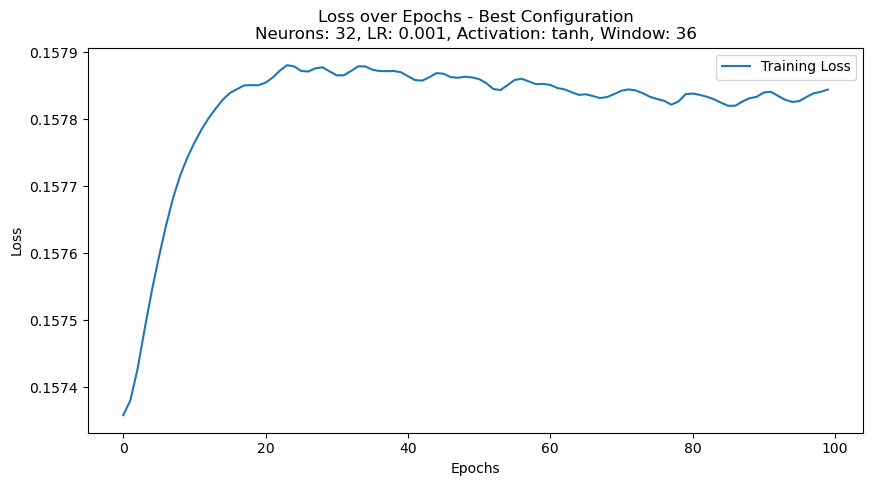

In [14]:
best_result = min(results, key=lambda x: x[4])
best_neurons, best_lr, best_activation, best_window, best_val_loss, best_epoch_losses = best_result

plt.figure(figsize=(10, 5))
plt.plot(best_epoch_losses, label='Training Loss')
plt.title(f'Loss over Epochs - Best Configuration\nNeurons: {best_neurons}, LR: {best_lr}, Activation: {best_activation}, Window: {best_window}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def create_features_and_labels(df, window_size=12):
    features = []
    labels = []

    for i in range(len(df)):
        if i < window_size:
            feature_set = np.zeros(window_size * 2)
        else:
            feature_set = df.iloc[i-window_size:i][['RET', 'vwretd']].values.flatten()
        features.append(feature_set)
        labels.append(df.iloc[i]['RET'])
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)


In [16]:
best_result = min(results, key=lambda x: x[4])
best_neurons, best_lr, best_activation, best_window, best_val_loss, best_epoch_losses = best_result

X_test_features, _ = create_features_and_labels(sampled_data[(sampled_data['date'] >= '2018-01-01') & (sampled_data['date'] <= '2023-12-31')], best_window)

X_test_tensor = torch.FloatTensor(X_test_features)

best_model = TuningNeuralBetaModel(input_size, best_neurons, best_activation)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test_tensor).squeeze().numpy()

test_data = sampled_data[(sampled_data['date'] >= '2018-01-01') & (sampled_data['date'] <= '2023-12-31')].copy()
test_data['beta'] = test_predictions

def compute_descriptive_stats(predictions, test_data):
    test_data['beta'] = predictions
    
    stats = test_data.groupby('SICCD')['beta'].agg(
        N='count',
        mean='mean',
        std='std',
        min='min',
        max='max',
        skewness=lambda x: skew(x),
        kurtosis=lambda x: kurtosis(x),
        p1=lambda x: np.percentile(x, 1),
        p5=lambda x: np.percentile(x, 5),
        p25=lambda x: np.percentile(x, 25),
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99)
    ).reset_index()
    
    return stats

descriptive_stats = compute_descriptive_stats(test_predictions, test_data)

descriptive_stats

,SICCD,N,mean,std,min,max,skewness,kurtosis,p1,p5,p25,p50,p75,p95,p99
0,0,38,0.105867,0.046205,0.012196,0.207539,0.133964,-0.597015,0.019128,0.031274,0.073794,0.103580,0.138355,0.174465,0.197292
1,1311,60,0.103364,0.046808,-0.002069,0.253534,0.905856,2.090198,0.007321,0.035538,0.075247,0.098688,0.124114,0.174371,0.243731
2,1321,19,0.094444,0.028645,0.042874,0.145946,0.087050,-0.943729,0.045622,0.056614,0.074927,0.093901,0.116844,0.136874,0.144132
3,1382,50,0.108115,0.065217,-0.049244,0.311924,0.544765,1.781751,-0.040134,0.004721,0.075273,0.097745,0.147677,0.213240,0.295017
4,1389,18,0.088860,0.045483,-0.016427,0.178894,-0.180187,0.214881,-0.007902,0.026200,0.064047,0.084189,0.125285,0.149654,0.173046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,7371,29,0.112920,0.049370,0.017121,0.198955,0.234508,-0.850972,0.025093,0.048717,0.070846,0.103888,0.146356,0.192517,0.197372
73,7372,60,0.097766,0.045538,-0.000501,0.221048,0.211740,-0.072786,0.012173,0.028712,0.070060,0.096961,0.121595,0.175338,0.199305
74,7389,60,0.090529,0.041124,-0.018594,0.177182,-0.061530,-0.221676,-0.000671,0.028413,0.064412,0.086316,0.115929,0.157913,0.170734
75,8731,20,0.094643,0.045325,0.008586,0.170914,-0.509367,-0.757319,0.010634,0.018827,0.066003,0.110051,0.125258,0.140964,0.164924


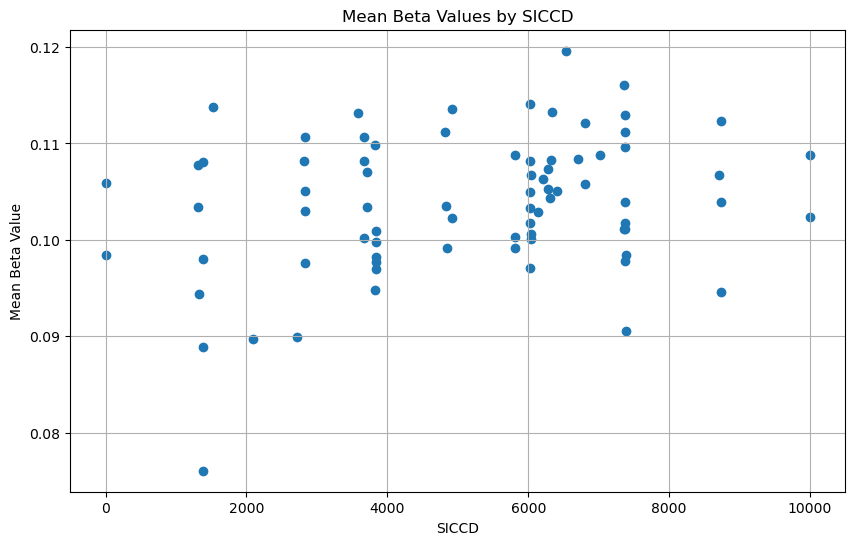

In [17]:


plt.figure(figsize=(10, 6))
plt.scatter(descriptive_stats['SICCD'], descriptive_stats['mean'], marker='o')
plt.title('Mean Beta Values by SICCD')
plt.xlabel('SICCD')
plt.ylabel('Mean Beta Value')
plt.grid()
plt.show()


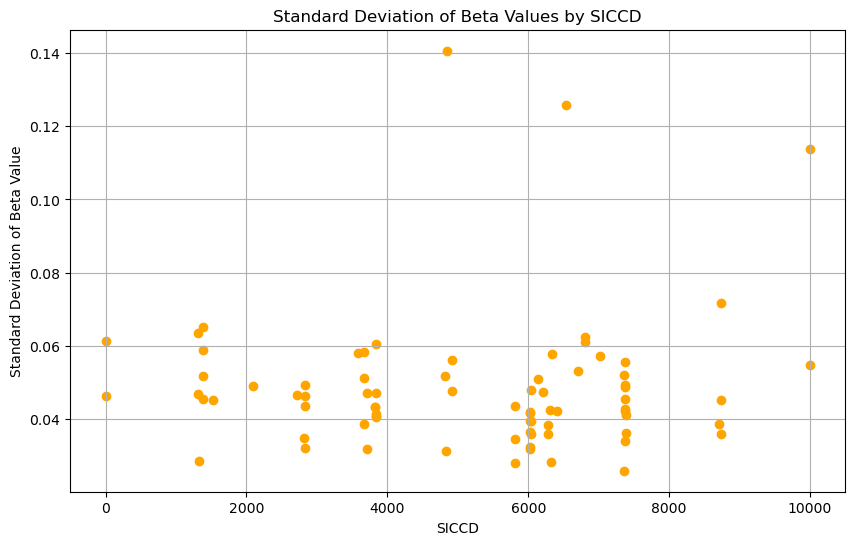

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(descriptive_stats['SICCD'], descriptive_stats['std'], marker='o', color='orange')
plt.title('Standard Deviation of Beta Values by SICCD')
plt.xlabel('SICCD')
plt.ylabel('Standard Deviation of Beta Value')
plt.grid()
plt.show()


In [6]:
sampled_data1 = sampled_data.copy()
sampled_data

,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,RETX,vwretd
0,86576,2005-03-31,11,6020,GBTB,G B & T BANCSHARES INC,16371,36146210,21.66,23.4876,21.660,8814.0,-0.067986,21.61,21.64,11790.0,-0.067986,-0.016944
1,86245,2005-08-31,11,6020,BWCF,B W C FINANCIAL CORP,16220,05604210,27.92,30.0000,27.920,871.0,-0.111076,27.60,28.00,4173.0,-0.113932,-0.005958
2,10913,2005-05-31,11,6020,FFKT,FARMERS CAPITAL BANK CORP,8788,30956210,32.25,33.5500,32.640,1125.0,0.006718,32.91,33.07,6782.0,-0.003359,0.037954
3,84140,2005-12-30,11,6020,UBCD,UNIONBANCORP INC,14996,15643B20,-21.00,21.4600,-21.075,223.0,-0.011955,20.90,21.25,3807.0,-0.011955,0.003458
4,10650,2005-09-30,11,6020,AABC,ACCESS ANYTIME BANCORP,8552,00431F10,16.06,17.8500,17.170,4785.0,0.194019,16.58,16.93,1634.0,0.194019,0.010600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15756,54148,2023-01-31,11,1531,PHM,PULTE GROUP INC,21349,74586710,46.20,56.8900,56.890,456711.0,0.249506,56.93,56.95,227820.0,0.249506,0.071823
15757,92089,2023-01-31,11,1531,GRBK,GREEN BRICK PARTNERS INC,52369,39270910,24.80,31.2000,31.200,59941.0,0.287660,31.20,31.21,46038.0,0.287660,0.071823
15758,77661,2023-06-30,11,1531,DHI,D R HORTON INC,11559,23331A10,108.48,123.0500,121.690,618202.0,0.138993,121.69,121.70,341071.0,0.138993,0.066183
15759,77661,2023-07-31,11,1531,DHI,D R HORTON INC,11559,23331A10,114.86,131.0000,127.020,643420.0,0.043800,127.01,127.02,338297.0,0.043800,0.035624


In [7]:
def compute_descriptive_stats(predictions, test_data):
    test_data['beta'] = predictions
    

    stats = test_data.groupby('SICCD')['beta'].agg(
        N='count',
        mean='mean',
        std='std',
        min='min',
        max='max',
        skewness=lambda x: skew(x),
        kurtosis=lambda x: kurtosis(x),
        p1=lambda x: np.percentile(x, 1),
        p5=lambda x: np.percentile(x, 5),
        p25=lambda x: np.percentile(x, 25),
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99)
    ).reset_index()
    
    return stats

In [8]:
def create_features_and_labels(df, window_size=12):
    features = []
    labels = []
    
    for i in range(len(df)):
        if i < window_size:

            feature_set = np.zeros(window_size * 2)
        else:
            feature_set = df.iloc[i-window_size:i][['RET', 'vwretd']].values.flatten()
        features.append(feature_set)
        labels.append(df.iloc[i]['RET'])
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

In [9]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv') 
ff_factors = ff_factors.dropna()
ff_factors.reset_index(drop=True, inplace=True)
ff_factors.head()

,Date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [12]:
sampled_data = sampled_data1
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15761 entries, 0 to 15760
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PERMNO  15761 non-null  int64         
 1   date    15761 non-null  datetime64[ns]
 2   SHRCD   15761 non-null  int64         
 3   SICCD   15761 non-null  object        
 4   TICKER  15761 non-null  object        
 5   COMNAM  15761 non-null  object        
 6   PERMCO  15761 non-null  int64         
 7   CUSIP   15761 non-null  object        
 8   BIDLO   15761 non-null  float64       
 9   ASKHI   15761 non-null  float64       
 10  PRC     15761 non-null  float64       
 11  VOL     15761 non-null  float64       
 12  RET     15761 non-null  object        
 13  BID     15761 non-null  float64       
 14  ASK     15761 non-null  float64       
 15  SHROUT  15761 non-null  float64       
 16  RETX    15761 non-null  object        
 17  vwretd  15761 non-null  float64       
dtypes: dat

In [18]:
def custom_loss_function(predictions, actuals, market_returns):
    return torch.sqrt(torch.mean((actuals - predictions.squeeze() * market_returns) ** 2))

sampled_data = sampled_data1
sampled_data['date'] = pd.to_datetime(sampled_data['date'], format='%Y%m', errors='coerce')
sampled_data['date'] = sampled_data['date'].dt.strftime('%Y%m')

ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv') 
ff_factors = ff_factors.dropna()
ff_factors.reset_index(drop=True, inplace=True)
ff_factors['date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
ff_factors['date'] = ff_factors['date'].dt.strftime('%Y%m')

ff_factors.rename(columns={'Mkt-RF': 'Mkt_RF', 'SMB': 'SMB_FF', 'HML': 'HML_FF', 'RF': 'RF_FF'}, inplace=True)

sampled_data = sampled_data.merge(ff_factors[['date', 'SMB_FF', 'HML_FF', 'Mkt_RF', 'RF_FF']], on='date', how='left')

sampled_data = sampled_data.dropna()
sampled_data.reset_index(drop=True, inplace=True)

sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15761 entries, 0 to 15760
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PERMNO  15761 non-null  int64  
 1   date    15761 non-null  object 
 2   SHRCD   15761 non-null  int64  
 3   SICCD   15761 non-null  object 
 4   TICKER  15761 non-null  object 
 5   COMNAM  15761 non-null  object 
 6   PERMCO  15761 non-null  int64  
 7   CUSIP   15761 non-null  object 
 8   BIDLO   15761 non-null  float64
 9   ASKHI   15761 non-null  float64
 10  PRC     15761 non-null  float64
 11  VOL     15761 non-null  float64
 12  RET     15761 non-null  object 
 13  BID     15761 non-null  float64
 14  ASK     15761 non-null  float64
 15  SHROUT  15761 non-null  float64
 16  RETX    15761 non-null  object 
 17  vwretd  15761 non-null  float64
 18  SMB_FF  15761 non-null  float64
 19  HML_FF  15761 non-null  float64
 20  Mkt_RF  15761 non-null  float64
 21  RF_FF   15761 non-null  float64
dty

In [25]:
def create_features_and_labels(df, window_size=12):
    features = []
    labels = []
    
    num_features = 5
    
    for i in range(len(df)):
        if i < window_size:
            feature_set = np.zeros(window_size * num_features)  
        else:
            feature_set = df.iloc[i-window_size:i][['RET', 'vwretd', 'SMB_FF', 'HML_FF', 'Mkt_RF']].values.flatten()
        
        features.append(feature_set)
        labels.append(df.iloc[i]['RET'])
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)



features_with_factors, labels_with_factors = create_features_and_labels(sampled_data)

X_train, X_temp, y_train, y_temp = train_test_split(features_with_factors, labels_with_factors, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

class UpdatedNeuralBetaModel(nn.Module):
    def __init__(self, input_size):
        super(UpdatedNeuralBetaModel, self).__init__()
        self.hidden_layer = nn.Linear(input_size, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

input_size_with_factors = X_train.shape[1]
updated_model = UpdatedNeuralBetaModel(input_size_with_factors)

optimizer = optim.Adam(updated_model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    updated_model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        batch_features = X_train_tensor[i:i + batch_size]
        batch_labels = y_train_tensor[i:i + batch_size]
        
        market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[i:i + len(batch_labels)]
        
        predictions = updated_model(batch_features).squeeze()
        loss = custom_loss_function(predictions, batch_labels, market_returns)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        updated_model.eval()
        with torch.no_grad():
            val_market_returns = torch.FloatTensor(np.array(sampled_data['vwretd']))[:len(X_val_tensor)]
            val_predictions = updated_model(X_val_tensor).squeeze()
            val_loss = custom_loss_function(val_predictions, y_val_tensor, val_market_returns)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')

X_test_features, _ = create_features_and_labels(sampled_data[(sampled_data['date'] >= '2018-01-01') & (sampled_data['date'] < '2024-01-01')], 12)

X_test_tensor = torch.FloatTensor(X_test_features)

best_model = updated_model

best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test_tensor).squeeze().numpy()

test_data = sampled_data[(sampled_data['date'] >= '2018-01-01') & (sampled_data['date'] <= '2024-01-01')].copy()
print(len(test_data))
test_data['beta'] = test_predictions

descriptive_stats_updated = compute_descriptive_stats(test_predictions, test_data)

descriptive_stats_updated

Epoch [10/100], Validation Loss: 0.2026
Epoch [20/100], Validation Loss: 0.2035
Epoch [30/100], Validation Loss: 0.2039
Epoch [40/100], Validation Loss: 0.2045
Epoch [50/100], Validation Loss: 0.2052
Epoch [60/100], Validation Loss: 0.2059
Epoch [70/100], Validation Loss: 0.2065
Epoch [80/100], Validation Loss: 0.2068
Epoch [90/100], Validation Loss: 0.2072
Epoch [100/100], Validation Loss: 0.2076
3683


,SICCD,N,mean,std,min,max,skewness,kurtosis,p1,p5,p25,p50,p75,p95,p99
0,0,38,0.298961,3.166645,-4.385437,10.553649,0.903167,1.290917,-4.331695,-4.189948,-1.978102,0.201874,1.541587,5.023574,8.943106
1,1311,60,0.295560,3.174894,-13.160061,7.932073,-0.820115,4.220306,-8.447318,-3.000990,-1.544484,0.157629,1.917113,5.223494,7.389612
2,1321,19,0.010154,2.024403,-4.510340,3.278923,-0.525714,-0.030881,-4.376094,-3.839109,-0.800408,-0.150772,1.341976,2.593036,3.141746
3,1382,50,0.378598,2.360262,-4.576380,6.463895,0.171421,0.023213,-4.506362,-3.555967,-1.009932,0.018326,1.903667,3.648302,5.945062
4,1389,18,0.324782,1.938961,-4.197326,3.020278,-0.747671,0.230034,-4.024788,-3.334637,-0.443637,0.619197,1.270338,2.942374,3.004697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,7371,29,-0.319897,2.114383,-5.116024,3.916371,-0.229547,-0.013750,-5.025193,-3.934555,-1.523916,-0.488645,1.071936,2.707937,3.584474
73,7372,60,-0.038309,1.773856,-5.645983,3.825964,-0.138789,0.818149,-4.173642,-2.754311,-1.083401,-0.184192,0.919424,3.174846,3.815975
74,7389,60,0.216397,2.656213,-9.404275,5.460816,-0.816917,1.962501,-7.686390,-3.636145,-1.143223,0.379714,1.743305,4.234451,5.223475
75,8731,20,0.139365,1.034885,-1.668456,1.847979,-0.036281,-1.027373,-1.630398,-1.478165,-0.650840,0.174491,1.006355,1.703930,1.819169


In [26]:
import pandas as pd

def calculate_portfolio_returns(beta_predictions, sampled_data, num_portfolios=5):
    sampled_data['beta'] = beta_predictions
    
    sampled_data['RET'] = pd.to_numeric(sampled_data['RET'], errors='coerce')
    
    sampled_data = sampled_data.dropna(subset=['RET'])

    sampled_data['quintile'] = pd.qcut(sampled_data['beta'], num_portfolios, labels=False) + 1

    equal_weighted_portfolio_returns = sampled_data.groupby('quintile')['RET'].mean()

    sampled_data['market_cap'] = sampled_data['PRC'] * sampled_data['SHROUT']
    
    value_weighted_portfolio_returns = sampled_data.groupby('quintile').apply(
        lambda x: (x['RET'] * x['market_cap']).sum() / x['market_cap'].sum()
    )

    equal_weighted_diff = equal_weighted_portfolio_returns.iloc[-1] - equal_weighted_portfolio_returns.iloc[0]
    value_weighted_diff = value_weighted_portfolio_returns.iloc[-1] - value_weighted_portfolio_returns.iloc[0]

    return equal_weighted_portfolio_returns, value_weighted_portfolio_returns, equal_weighted_diff, value_weighted_diff

equal_weighted_returns, value_weighted_returns, equal_weighted_diff, value_weighted_diff = calculate_portfolio_returns(
    test_predictions, test_data
)

print("Equal-weighted portfolio returns by quintile:")
print(equal_weighted_returns)

print("Value-weighted portfolio returns by quintile:")
print(value_weighted_returns)

print(f"Long-short equal-weighted portfolio return: {equal_weighted_diff}")
print(f"Long-short value-weighted portfolio return: {value_weighted_diff}")

Equal-weighted portfolio returns by quintile:
quintile
1   -0.003885
2   -0.006525
3    0.001875
4    0.006491
5    0.039233
Name: RET, dtype: float64
Value-weighted portfolio returns by quintile:
quintile
1    0.001078
2    0.022540
3    0.057605
4    0.037296
5    0.051639
dtype: float64
Long-short equal-weighted portfolio return: 0.043117951153324285
Long-short value-weighted portfolio return: 0.050560986404280035


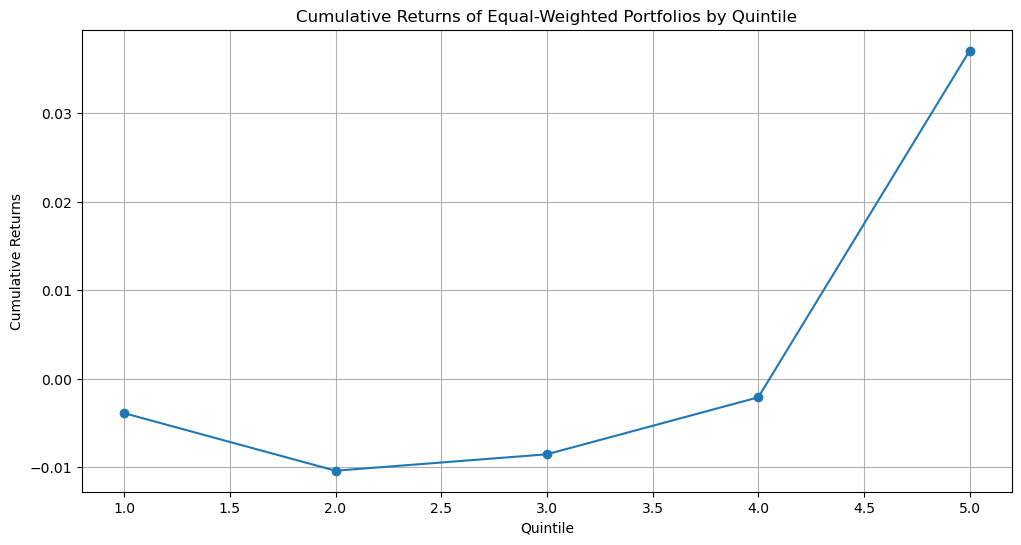

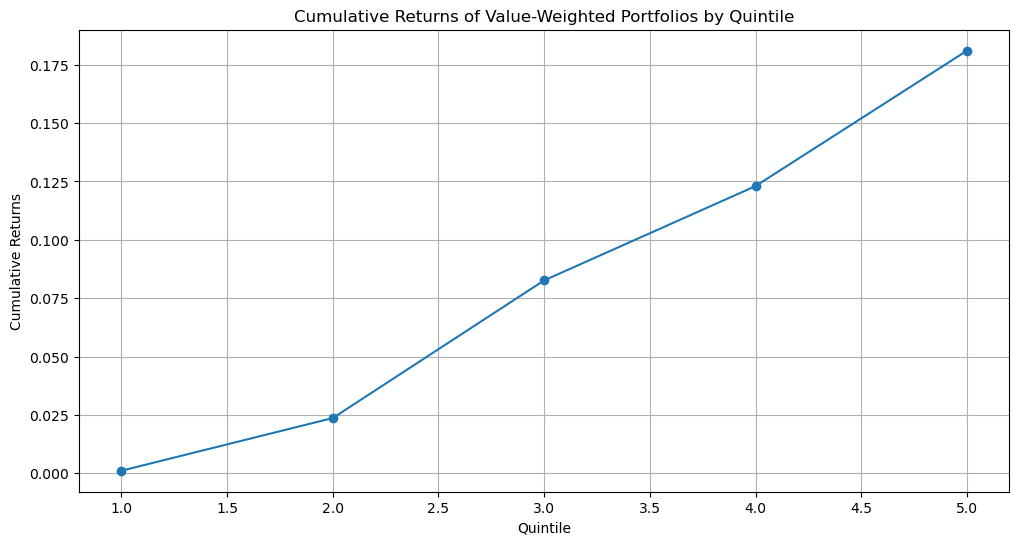

In [27]:
import matplotlib.pyplot as plt

def calculate_cumulative_returns(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    return cumulative_returns

equal_weighted_cumulative_returns = calculate_cumulative_returns(equal_weighted_returns)
value_weighted_cumulative_returns = calculate_cumulative_returns(value_weighted_returns)

plt.figure(figsize=(12, 6))
equal_weighted_cumulative_returns.plot(title="Cumulative Returns of Equal-Weighted Portfolios by Quintile", marker='o')
plt.xlabel("Quintile")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
value_weighted_cumulative_returns.plot(title="Cumulative Returns of Value-Weighted Portfolios by Quintile", marker='o')
plt.xlabel("Quintile")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()